# Overall Workflow
## 1. The Dataset
## 2. Missing Value Exploration
## 3. Initial Data Cleaning - Remove irrelevant features
## 4. Outlier Exploration
## 5. Feature Selection - Visualization & Hypothesis testing

# Packages

In [1]:
# Data structures
import numpy as np
import pandas as pd

# Data formats
import csv
import json

# Visualizations
import matplotlib.pyplot as plt
import seaborn as sb
plt.style.use("ggplot")

# Statistical testings
from scipy.stats import f
from scipy.stats import ttest_ind
from scipy.stats import chi2_contingency

# Data preprocessing
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

# Machine learning algorithm
from sklearn.linear_model import SGDClassifier

# Hyperparameter tuning
from hyperopt import hp
from hyperopt import Trials
from hyperopt import tpe
from timeit import default_timer as timer
from hyperopt import STATUS_OK
from hyperopt import fmin

# Model validation
from sklearn.model_selection import cross_validate
from sklearn.metrics import classification_report
from sklearn.metrics import precision_score, accuracy_score, recall_score, f1_score, roc_auc_score, roc_curve, auc, confusion_matrix

# 1. The dataset

In [2]:
data = pd.read_csv('data.csv')
data.head()

id diagnosis  radius_mean  texture_mean  perimeter_mean  area_mean  \
0    842302         M        17.99         10.38          122.80     1001.0   
1    842517         M        20.57         17.77          132.90     1326.0   
2  84300903         M        19.69         21.25          130.00     1203.0   
3  84348301         M        11.42         20.38           77.58      386.1   
4  84358402         M        20.29         14.34          135.10     1297.0   

   smoothness_mean  compactness_mean  concavity_mean  concave points_mean  \
0          0.11840           0.27760          0.3001              0.14710   
1          0.08474           0.07864          0.0869              0.07017   
2          0.10960           0.15990          0.1974              0.12790   
3          0.14250           0.28390          0.2414              0.10520   
4          0.10030           0.13280          0.1980              0.10430   

      ...       texture_worst  perimeter_worst  area_worst  smoothness_worst  \
0     ...               17.33           184.60      2019.0            0.1622   
1     ...               23.41           158.80      1956.0            0.1238   
2     ...               25.53           152.50      1709.0            0.1444   
3     ...               26.50            98.87       567.7            0.2098   
4     ...               16.67           152.20      1575.0            0.1374   

   compactness_worst  concavity_worst  concave points_worst  symmetry_worst  \
0             0.6656           0.7119                0.2654          0.4601   
1             0.1866           0.2416                0.1860          0.2750   
2             0.4245           0.4504                0.2430          0.3613   
3             0.8663           0.6869                0.2575          0.6638   
4             0.2050           0.4000                0.1625          0.2364   

   fractal_dimension_worst  Unnamed: 32  
0                  0.11890          NaN  
1                  0.08902          NaN  
2                  0.08758          NaN  
3                  0.17300          NaN  
4                  0.07678          NaN  

[5 rows x 33 columns]

In [3]:
# 569 rows with 33 features
data.shape

(569, 33)

# 2. Missing Value Exploration

In [4]:
# Loop through columns.
i = 0
for col in data.columns:
    if data[col].isnull().sum() != 0:
        print('{} has missing data!'.format(col))
        i+=1
    else:
        continue
print('{} columns have missing data!'.format(i))

Unnamed: 32 has missing data!
1 columns have missing data!


In [5]:
# After inspecting this column, it's an empty column.
data.drop(columns='Unnamed: 32', inplace = True)

In [6]:
# Now, I left with 32 columns.
data.shape

(569, 32)

# 3. Initial Data Cleaning - Remove irrelevant features

In [7]:
# Irrelevant features could be 'patient id'.
# If a column contained the number of records corresponding to the same length of the rows 
# or only contained one record, this column (predictor) might be an irrelevant feature.
for col in data.columns:
    if len(data[col].unique()) == data.shape[0]:
        print(col)
    elif len(data[col].unique()) == 1:
        print(col)           
    else:
        continue  

id


In [8]:
# Now, I left with 31 columns.
data.drop(columns='id', inplace = True)
data.shape

(569, 31)

# 4. Outlier Exploration
- **4.1 Box-plot visualizations**
- **4.2 Density distribution visualizations - predictors**
- **4.3 Density distribution visualizations - response**

## 4.1 Box-plot visualizations

In [9]:
# Find out which column is a numerical type. 
# 30 columns are numerical types.
numeric_col = 0
for col in data.columns:
    if (data[col].dtype) != 'object':
        numeric_col += 1
print('{} numerical columns.'.format(numeric_col))

30 numerical columns.


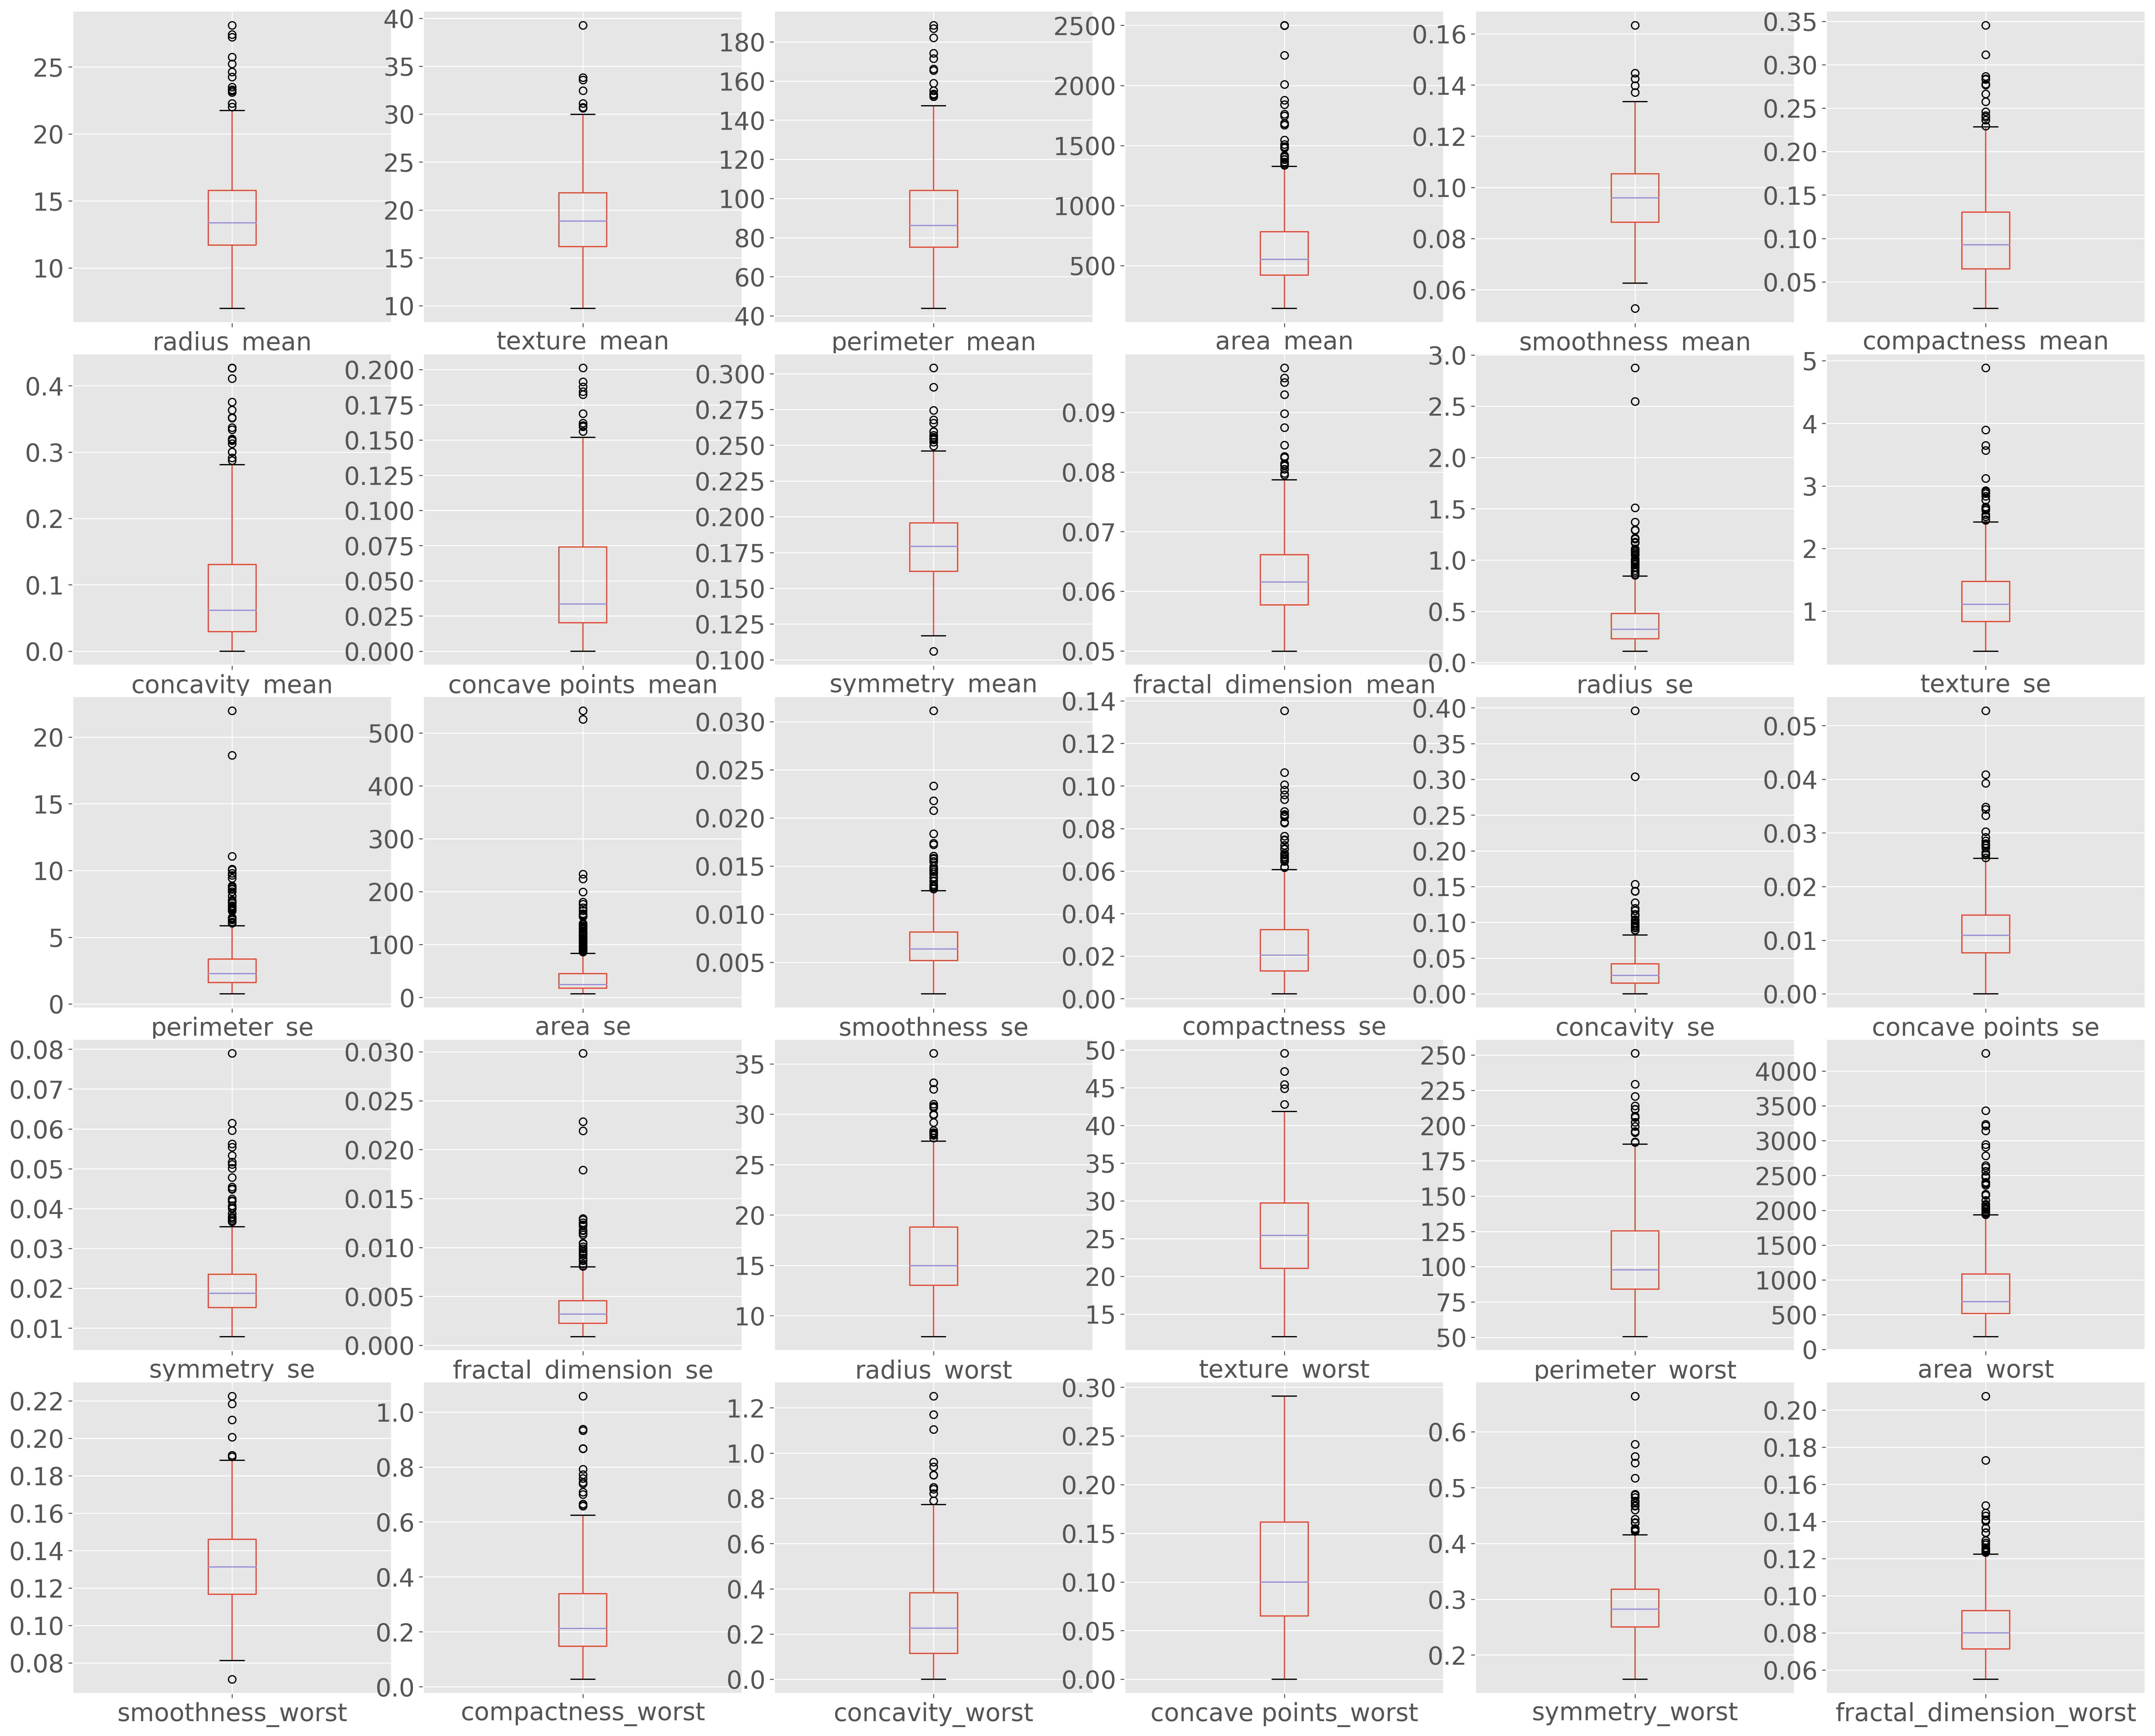

In [10]:
# Box-plot helps me to inspect the overall data distribution in numerical predictors.
# At the same time, outliers can be easily spotted.
# At here, I chose to not imputate any outlier to see how much accuracy score 
# (or other metrics) I can achieve. 
fig = plt.figure(figsize=(30,25), dpi=300)
fig.subplots_adjust(hspace=0.1, wspace=0.1)

count = 0

for col in data.columns:
    if data[col].dtype != 'object':
        count += 1
        ax = fig.add_subplot(5,6, count)
        data[col].plot(kind='box', use_index=True, fontsize = 20)

## 4.2 Density distribution visualizations - predictors

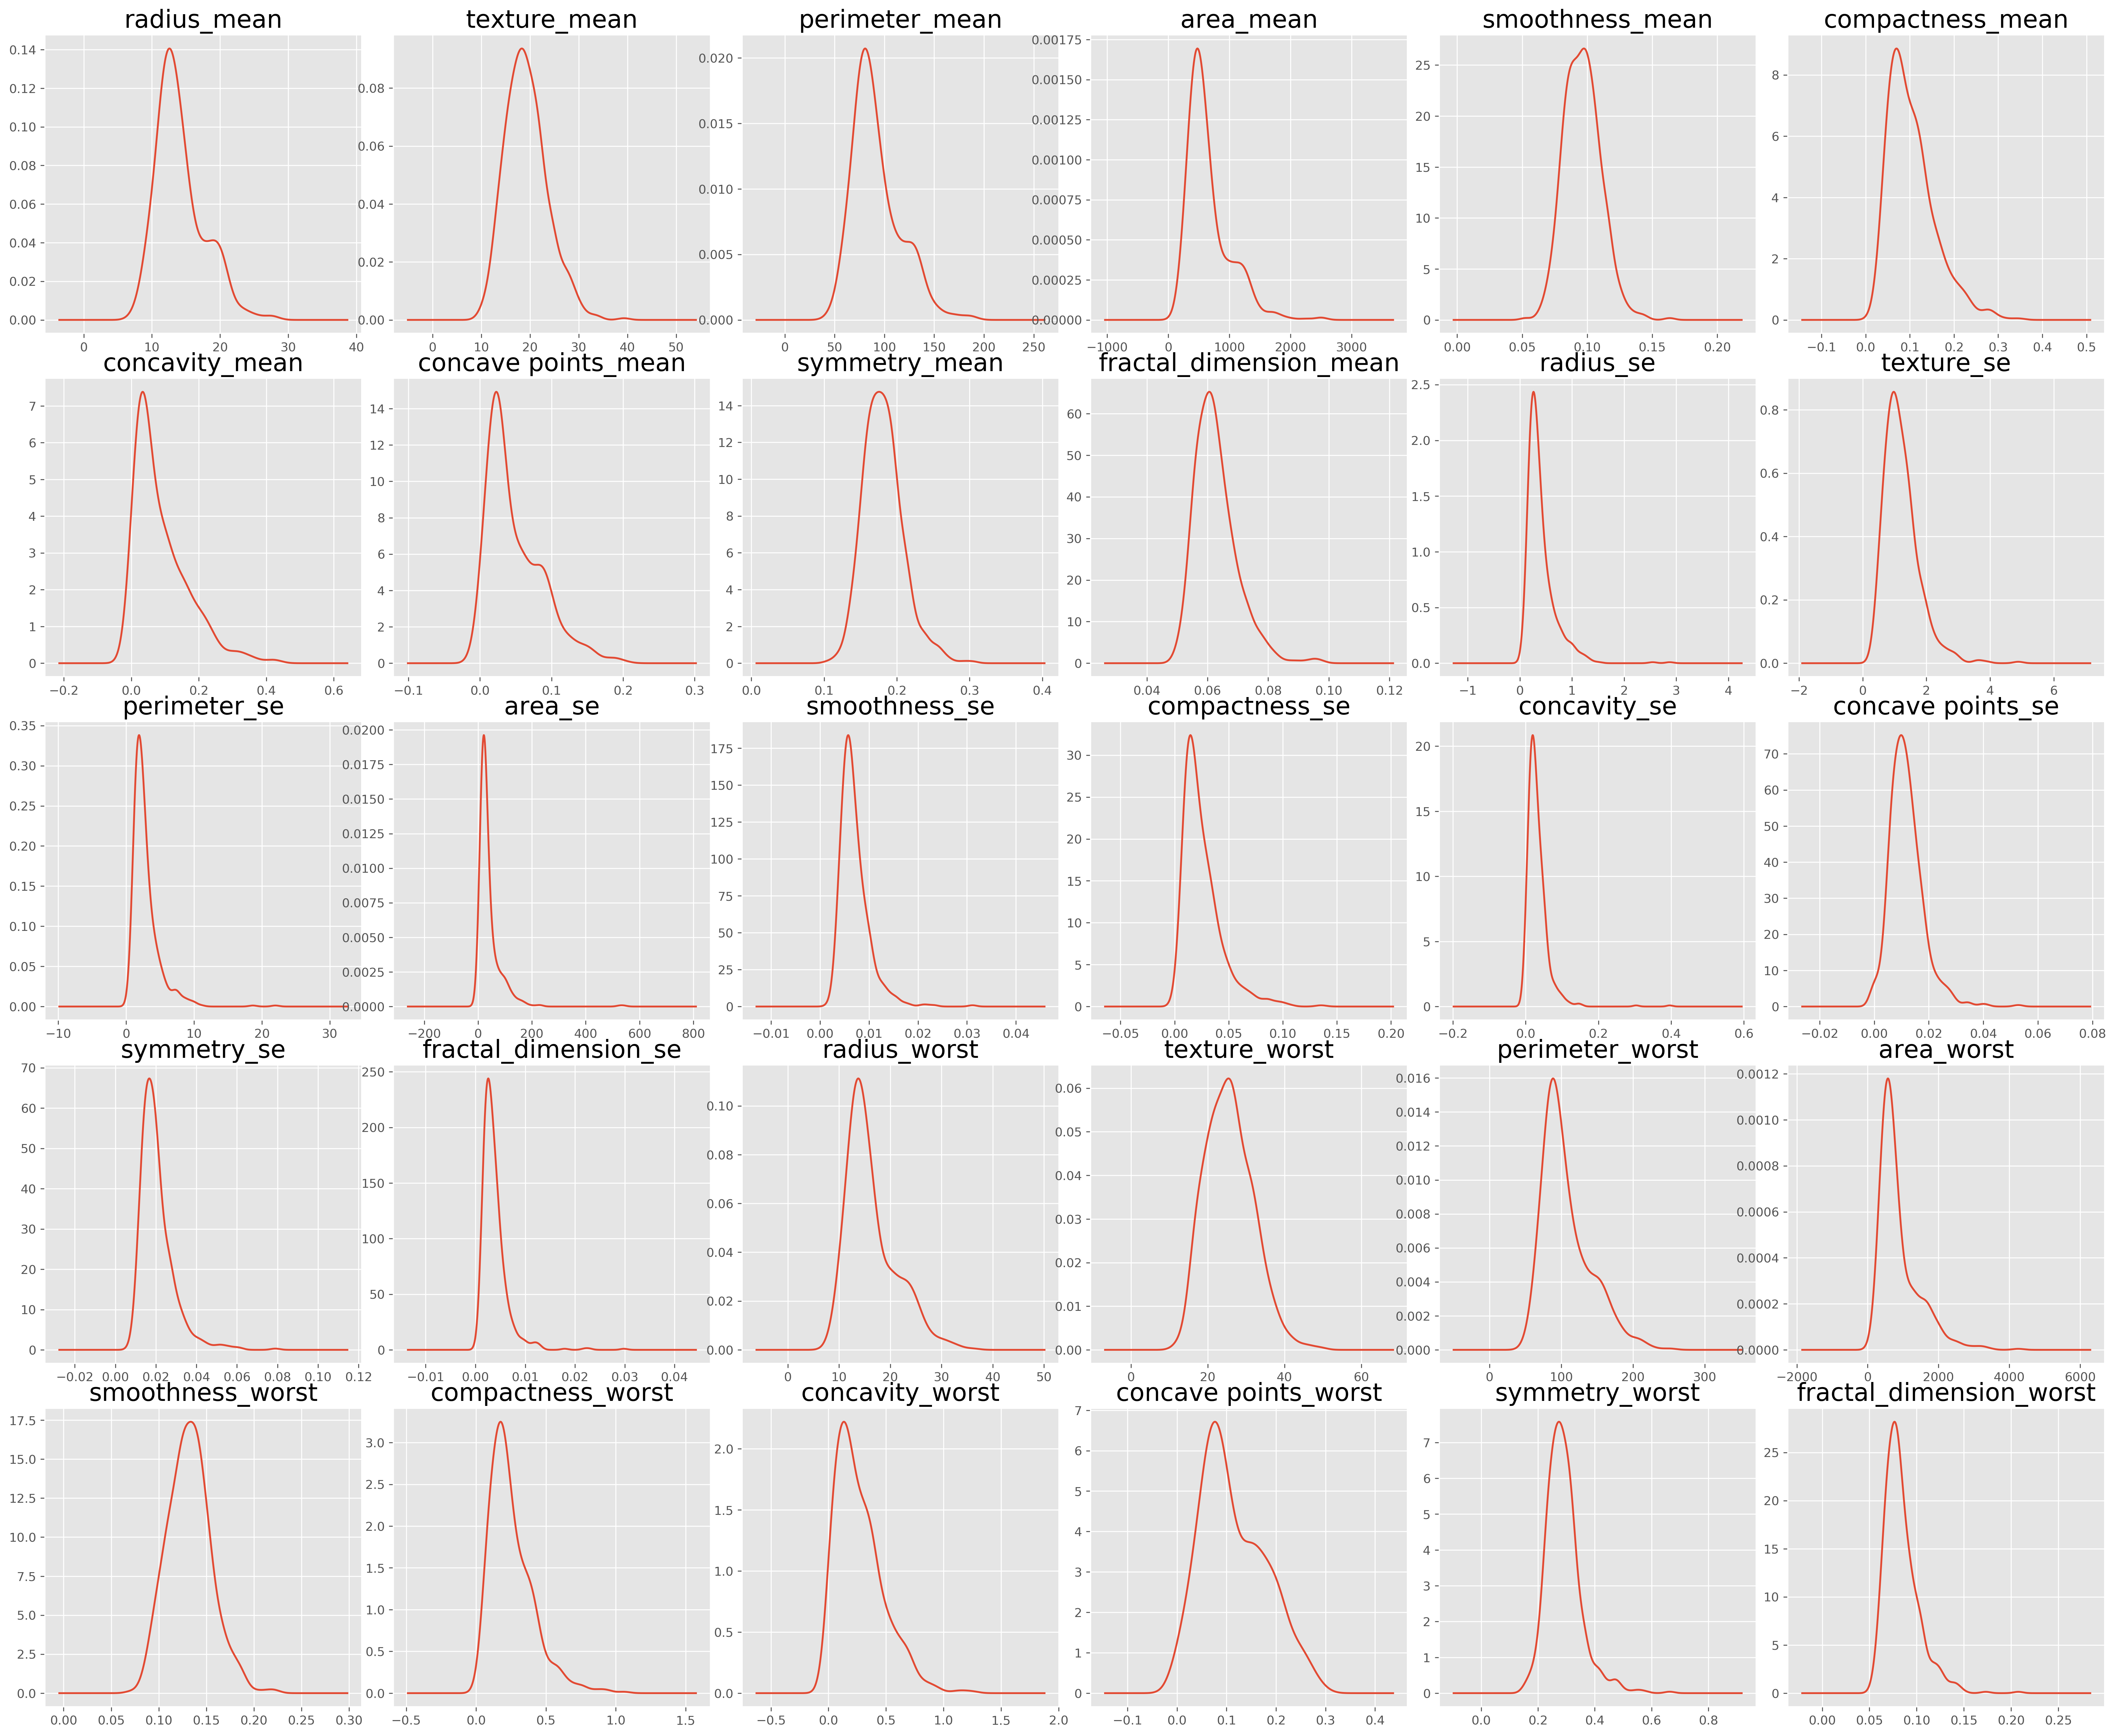

In [11]:
# Density plots help me not only inspect the data distribution in numerical predictors 
# but also tell the shape of the distribution such as right or left skew distribution.
# Many columns are in right skew shape, such as radius_se, perimeter_se, and so on.
fig = plt.figure(figsize=(30,25),dpi=300)
fig.subplots_adjust(hspace=0.15, wspace=0.1)

count = 0

for col in data.columns:
    if data[col].dtype != 'object':
        count += 1
        ax = fig.add_subplot(5,6, count)
        data[col].plot(kind='density', use_index=True)
        plt.ylabel('')
        plt.title(col, fontsize=20)

## 4.3 Density distribution visualizations - response

Text(0.5, 1.0, 'diagnosis')

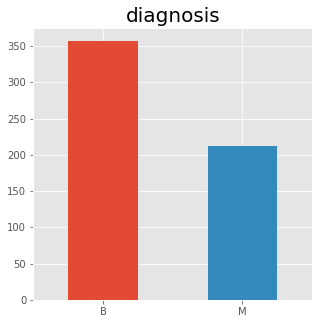

In [12]:
fig = plt.figure(figsize=(5,5))
data.diagnosis.value_counts().plot(kind = 'bar', rot = 360)
plt.title('diagnosis',fontsize=20)

In [13]:
# Label distribution is kind of unbalanced (60% vs 40%).
data.diagnosis.value_counts() / data.shape[0]

B    0.627417
M    0.372583
Name: diagnosis, dtype: float64

# 5. Feature Selection - Visualization & Hypothesis testing
- **5.1 Distribution plots - numerical features VS response**
- **5.2 Relationship between numerical predictors: Correlation Plot**
- **5.3 Distribution plots - categorical features**
- **5.4 Hypothesis testing - two sample t-test for numerical features**
- **5.5 Overall feature selection summary**

## 5.1 Distribution plots - numerical features VS response

In [14]:
# Helper function for inspecting the relationship between numerical features 
# and the response variable.
def num_feature_distribution_plot(col_name, response_name, data):
    plt.figure(figsize = (10, 8))

    # KDE plot of y = 0 
    sb.kdeplot(data.loc[data[response_name] == 'M', col_name], label = 'malignant')
    
    # KDE plot of y = 1 
    sb.kdeplot(data.loc[data[response_name] == 'B', col_name], label = 'benign')

    # Labeling
    plt.xlabel(col_name)
    plt.title('Distribution of '+ col_name, fontsize=20)

/Users/wuchenhong/anaconda3/lib/python3.6/site-packages/matplotlib/pyplot.py:514: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


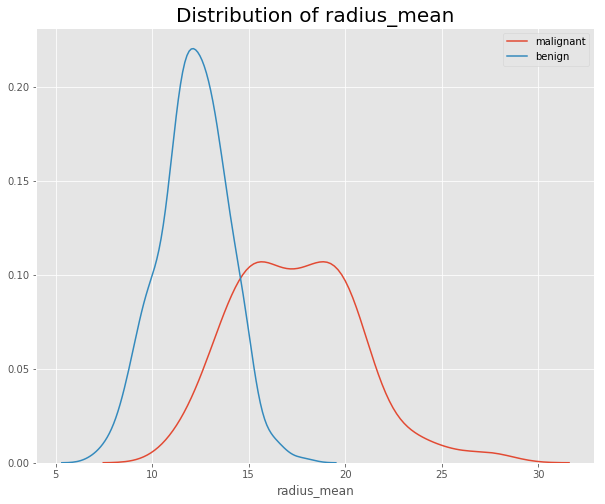

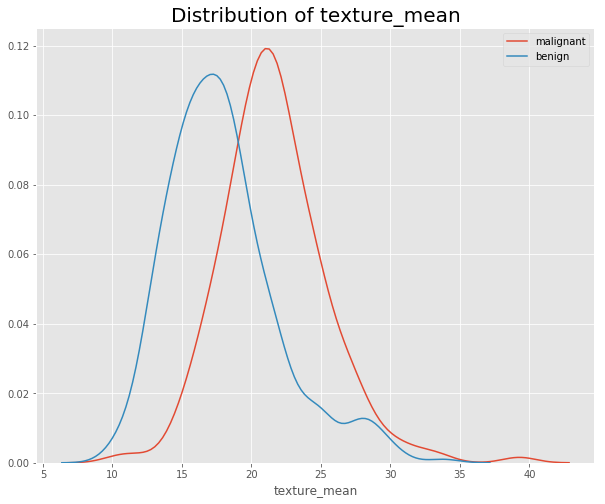

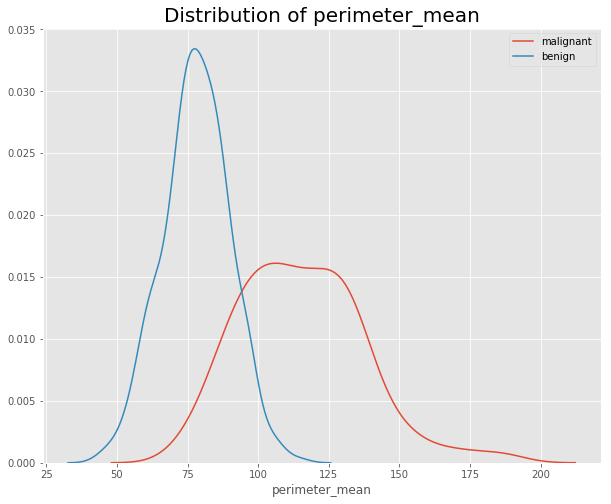

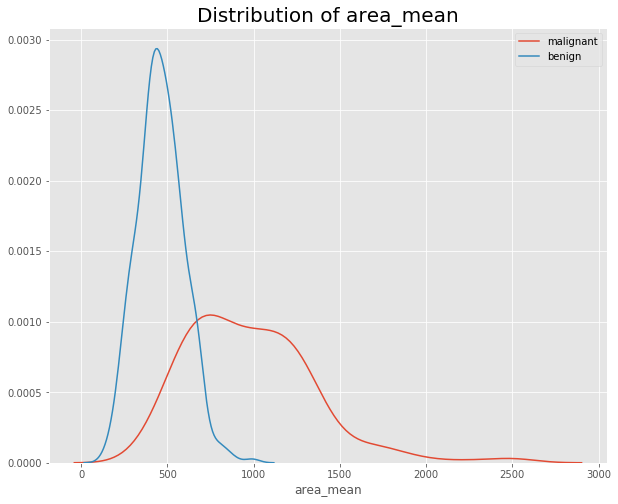

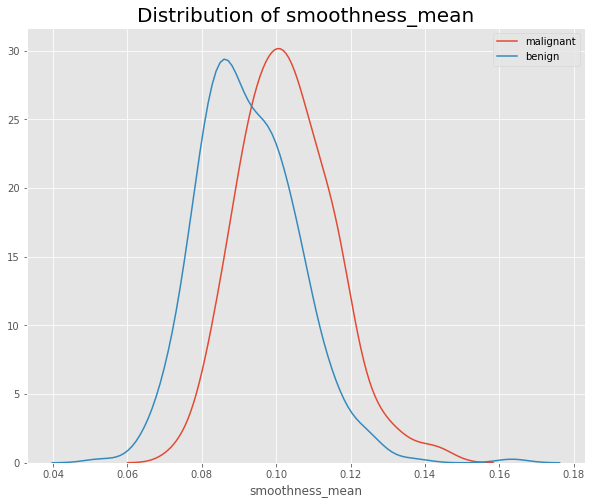

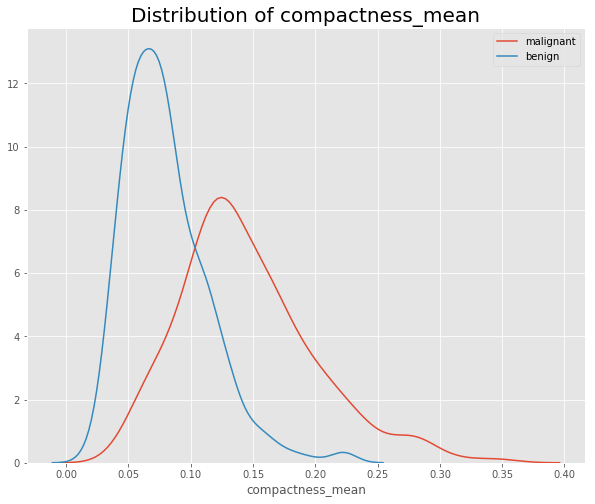

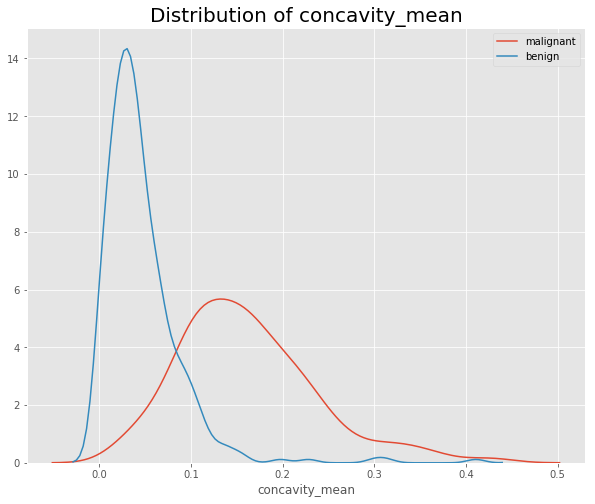

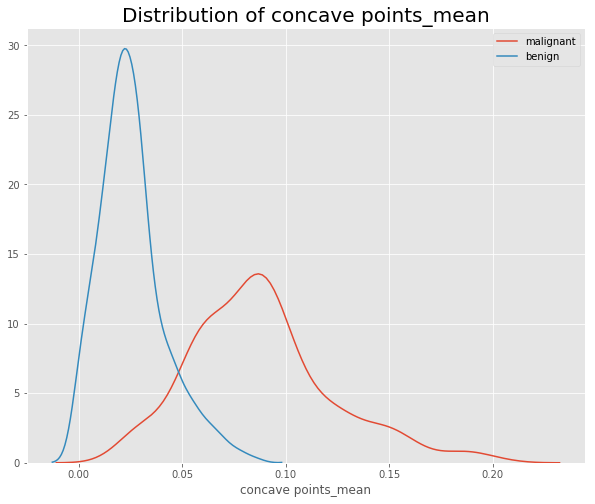

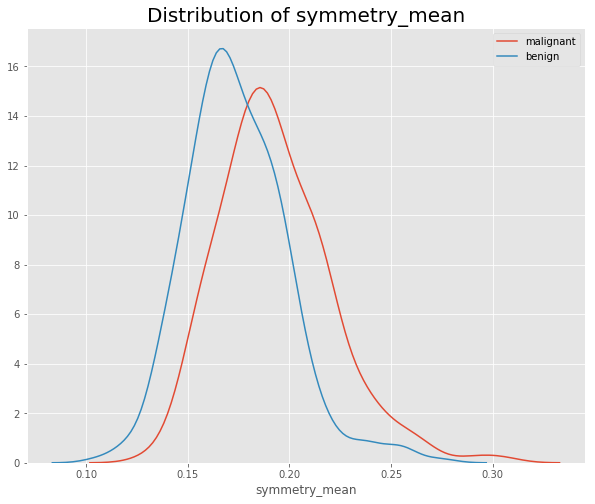

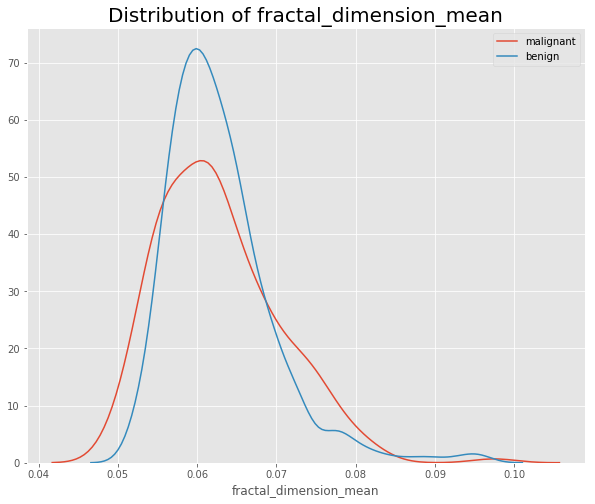

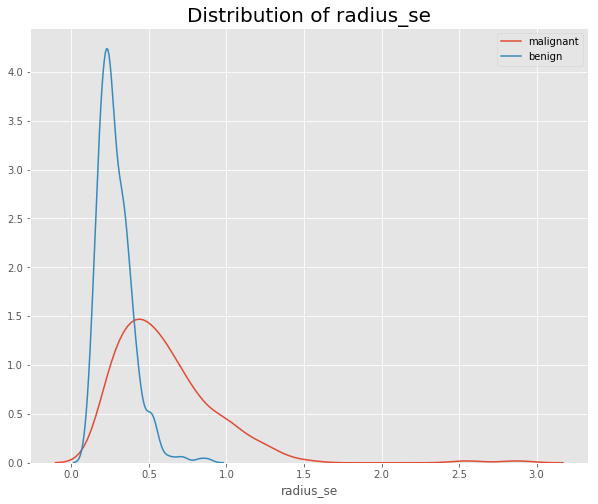

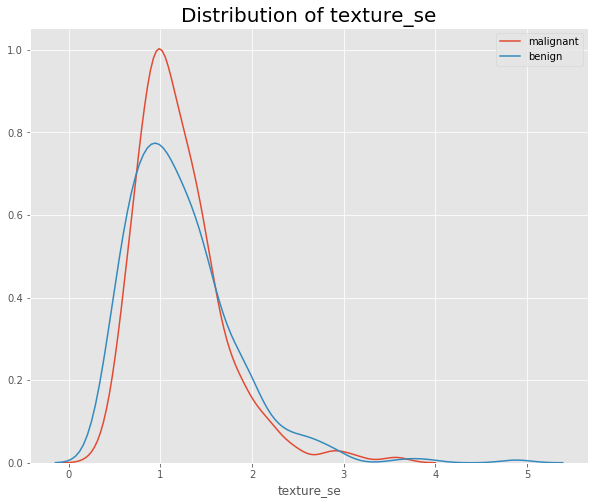

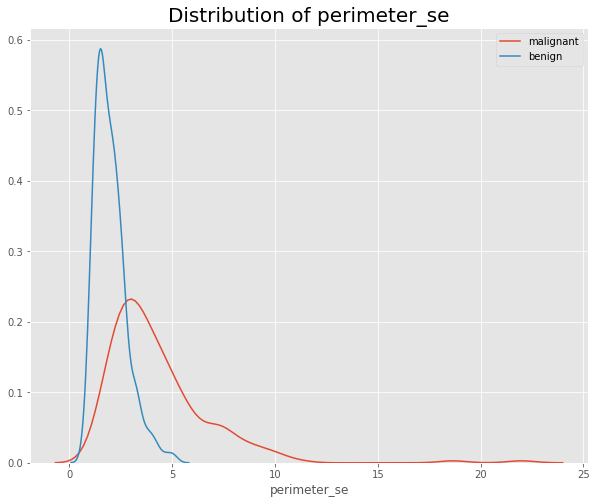

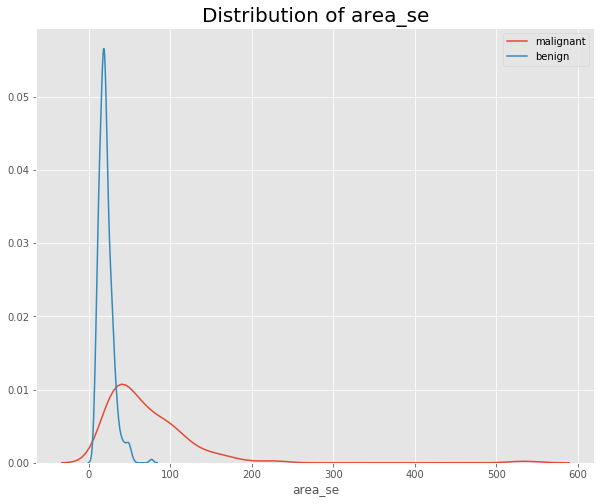

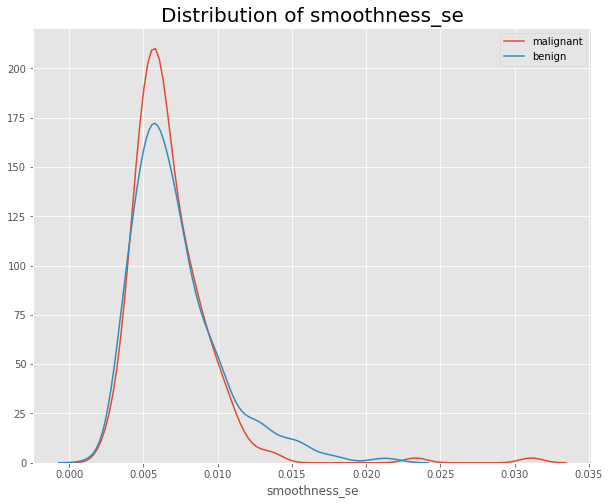

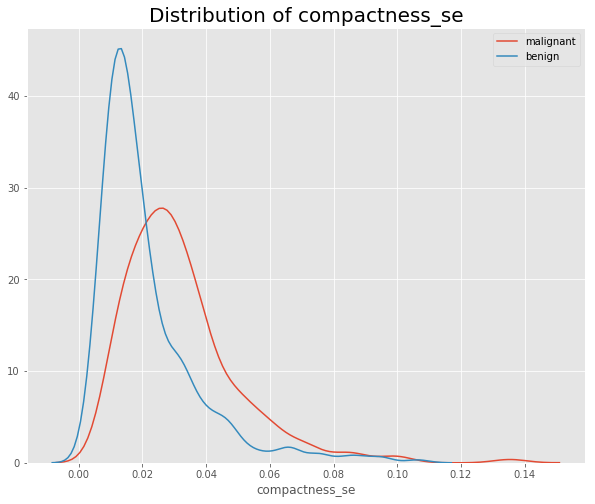

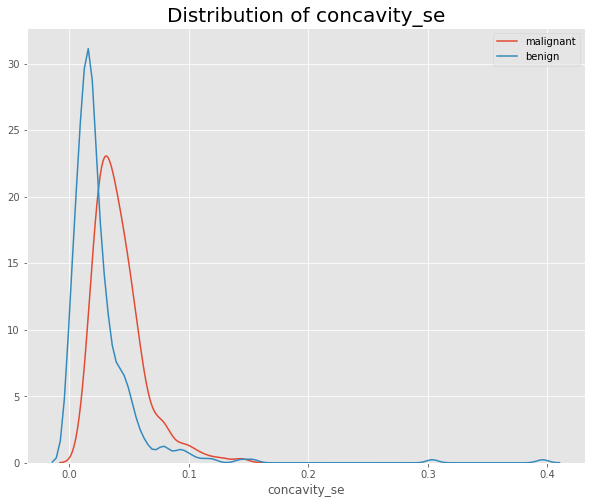

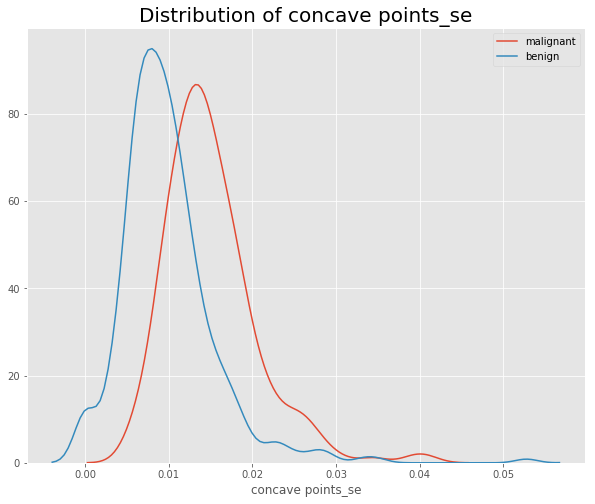

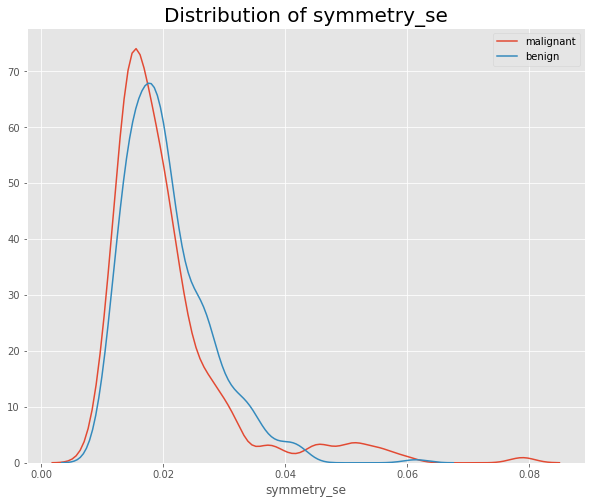

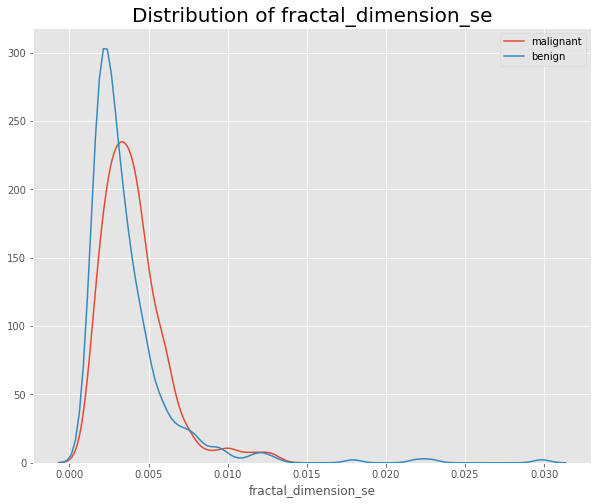

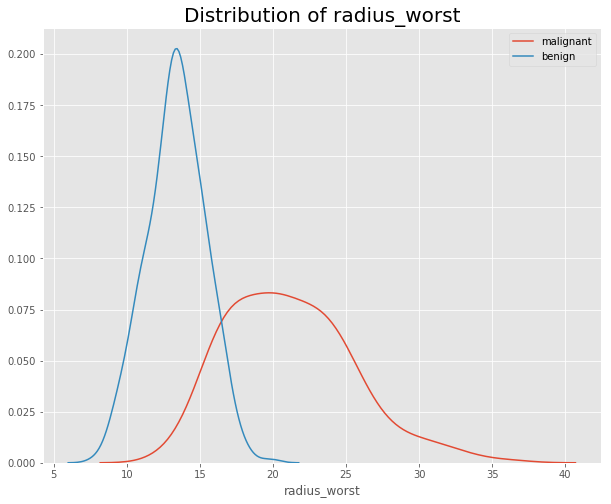

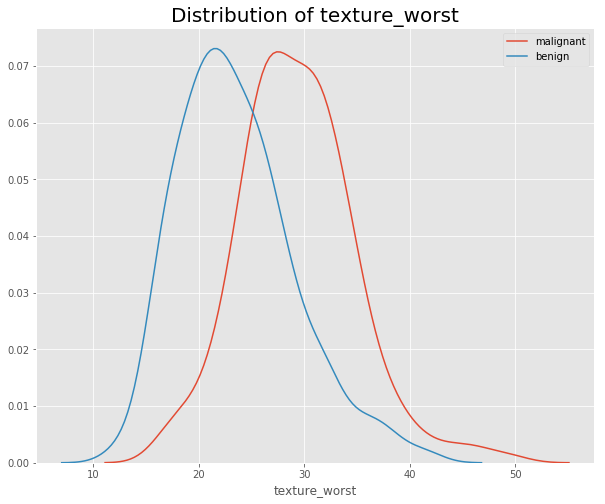

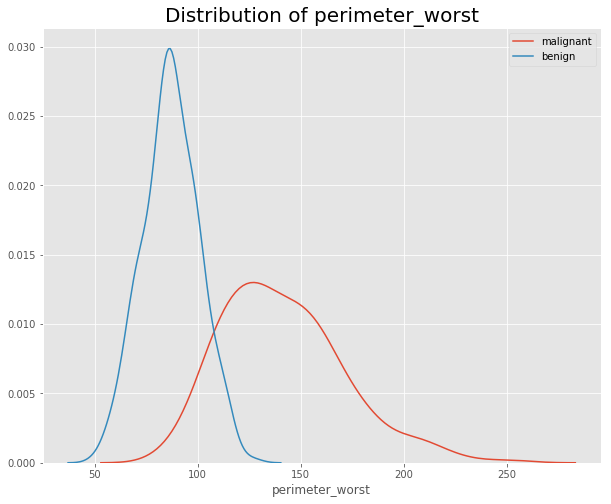

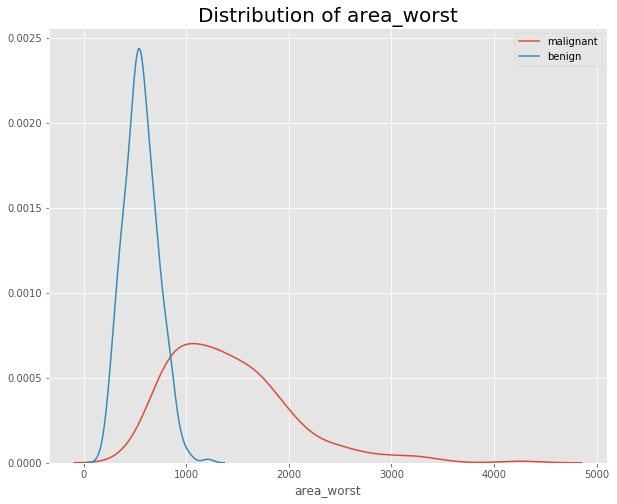

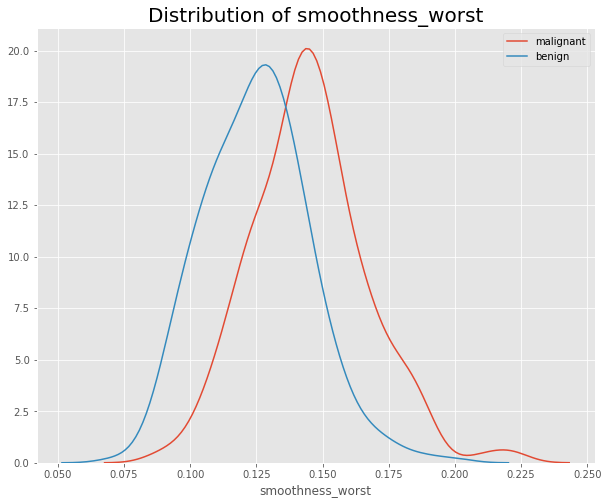

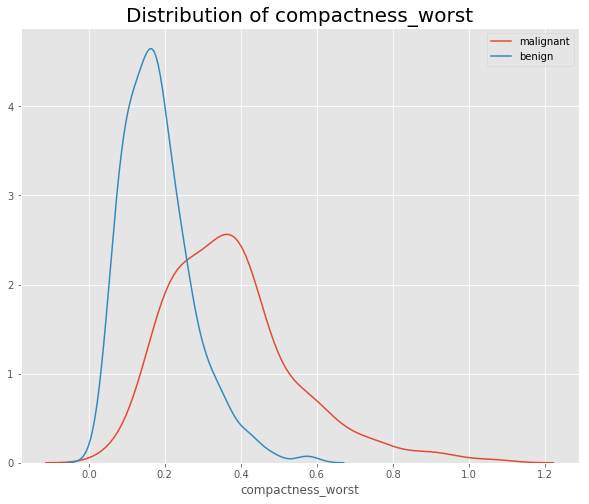

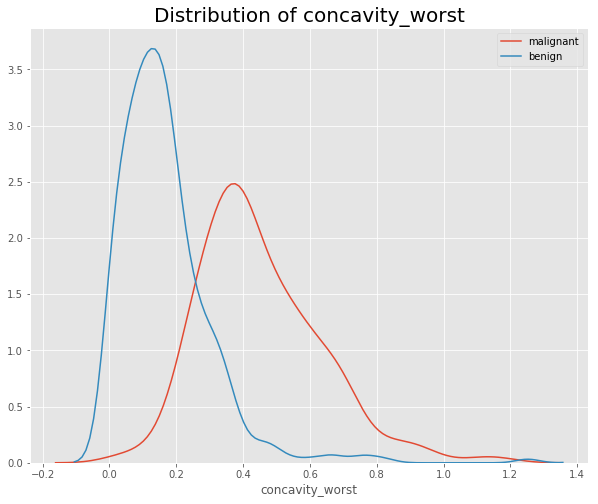

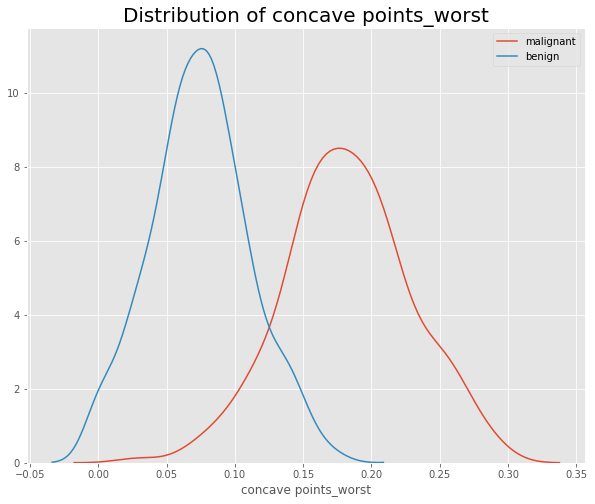

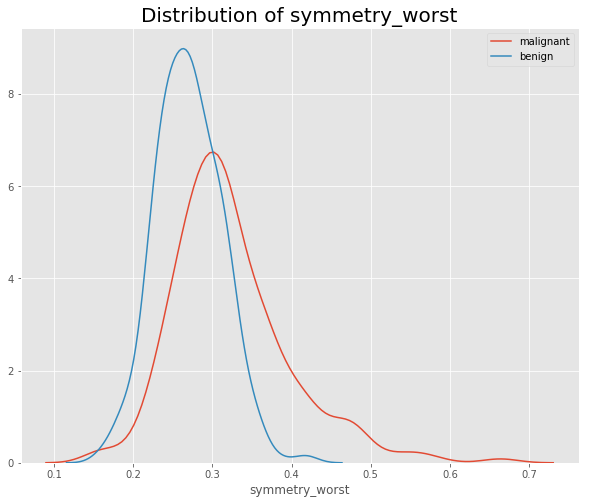

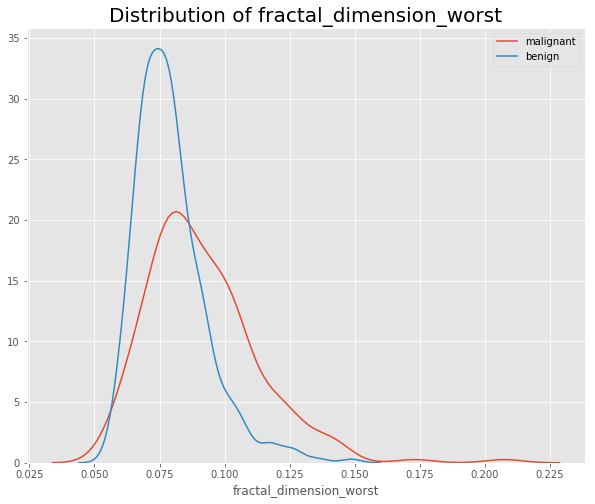

In [15]:
# 'smoothness_se' and 'symmetry_se' might not be good predictors for distinguishing 
# response variables since two lines are overlapped to each other.
for col in data.columns:
    if data[col].dtype != 'object':
        num_feature_distribution_plot(col_name=col, response_name='diagnosis', data=data)

## 5.2 Relationship between numerical predictors: Correlation Plot

In [16]:
num_col_names = []
for col in data.columns:
    if data[col].dtype != 'object':
        num_col_names.append(col)
        
correlation_matrix = data[num_col_names].corr()
mask = np.zeros_like(correlation_matrix)
mask[np.triu_indices_from(mask)] = True

In [17]:
# The correlation matrix shape is 30 x 30
correlation_matrix

radius_mean  texture_mean  perimeter_mean  area_mean  \
radius_mean                 1.000000      0.323782        0.997855   0.987357   
texture_mean                0.323782      1.000000        0.329533   0.321086   
perimeter_mean              0.997855      0.329533        1.000000   0.986507   
area_mean                   0.987357      0.321086        0.986507   1.000000   
smoothness_mean             0.170581     -0.023389        0.207278   0.177028   
compactness_mean            0.506124      0.236702        0.556936   0.498502   
concavity_mean              0.676764      0.302418        0.716136   0.685983   
concave points_mean         0.822529      0.293464        0.850977   0.823269   
symmetry_mean               0.147741      0.071401        0.183027   0.151293   
fractal_dimension_mean     -0.311631     -0.076437       -0.261477  -0.283110   
radius_se                   0.679090      0.275869        0.691765   0.732562   
texture_se                 -0.097317      0.386358       -0.086761  -0.066280   
perimeter_se                0.674172      0.281673        0.693135   0.726628   
area_se                     0.735864      0.259845        0.744983   0.800086   
smoothness_se              -0.222600      0.006614       -0.202694  -0.166777   
compactness_se              0.206000      0.191975        0.250744   0.212583   
concavity_se                0.194204      0.143293        0.228082   0.207660   
concave points_se           0.376169      0.163851        0.407217   0.372320   
symmetry_se                -0.104321      0.009127       -0.081629  -0.072497   
fractal_dimension_se       -0.042641      0.054458       -0.005523  -0.019887   
radius_worst                0.969539      0.352573        0.969476   0.962746   
texture_worst               0.297008      0.912045        0.303038   0.287489   
perimeter_worst             0.965137      0.358040        0.970387   0.959120   
area_worst                  0.941082      0.343546        0.941550   0.959213   
smoothness_worst            0.119616      0.077503        0.150549   0.123523   
compactness_worst           0.413463      0.277830        0.455774   0.390410   
concavity_worst             0.526911      0.301025        0.563879   0.512606   
concave points_worst        0.744214      0.295316        0.771241   0.722017   
symmetry_worst              0.163953      0.105008        0.189115   0.143570   
fractal_dimension_worst     0.007066      0.119205        0.051019   0.003738   

                         smoothness_mean  compactness_mean  concavity_mean  \
radius_mean                     0.170581          0.506124        0.676764   
texture_mean                   -0.023389          0.236702        0.302418   
perimeter_mean                  0.207278          0.556936        0.716136   
area_mean                       0.177028          0.498502        0.685983   
smoothness_mean                 1.000000          0.659123        0.521984   
compactness_mean                0.659123          1.000000        0.883121   
concavity_mean                  0.521984          0.883121        1.000000   
concave points_mean             0.553695          0.831135        0.921391   
symmetry_mean                   0.557775          0.602641        0.500667   
fractal_dimension_mean          0.584792          0.565369        0.336783   
radius_se                       0.301467          0.497473        0.631925   
texture_se                      0.068406          0.046205        0.076218   
perimeter_se                    0.296092          0.548905        0.660391   
area_se                         0.246552          0.455653        0.617427   
smoothness_se                   0.332375          0.135299        0.098564   
compactness_se                  0.318943          0.738722        0.670279   
concavity_se                    0.248396          0.570517        0.691270   
concave points_se               0.380676          0.642262        0.683260   
symmetry_se                    

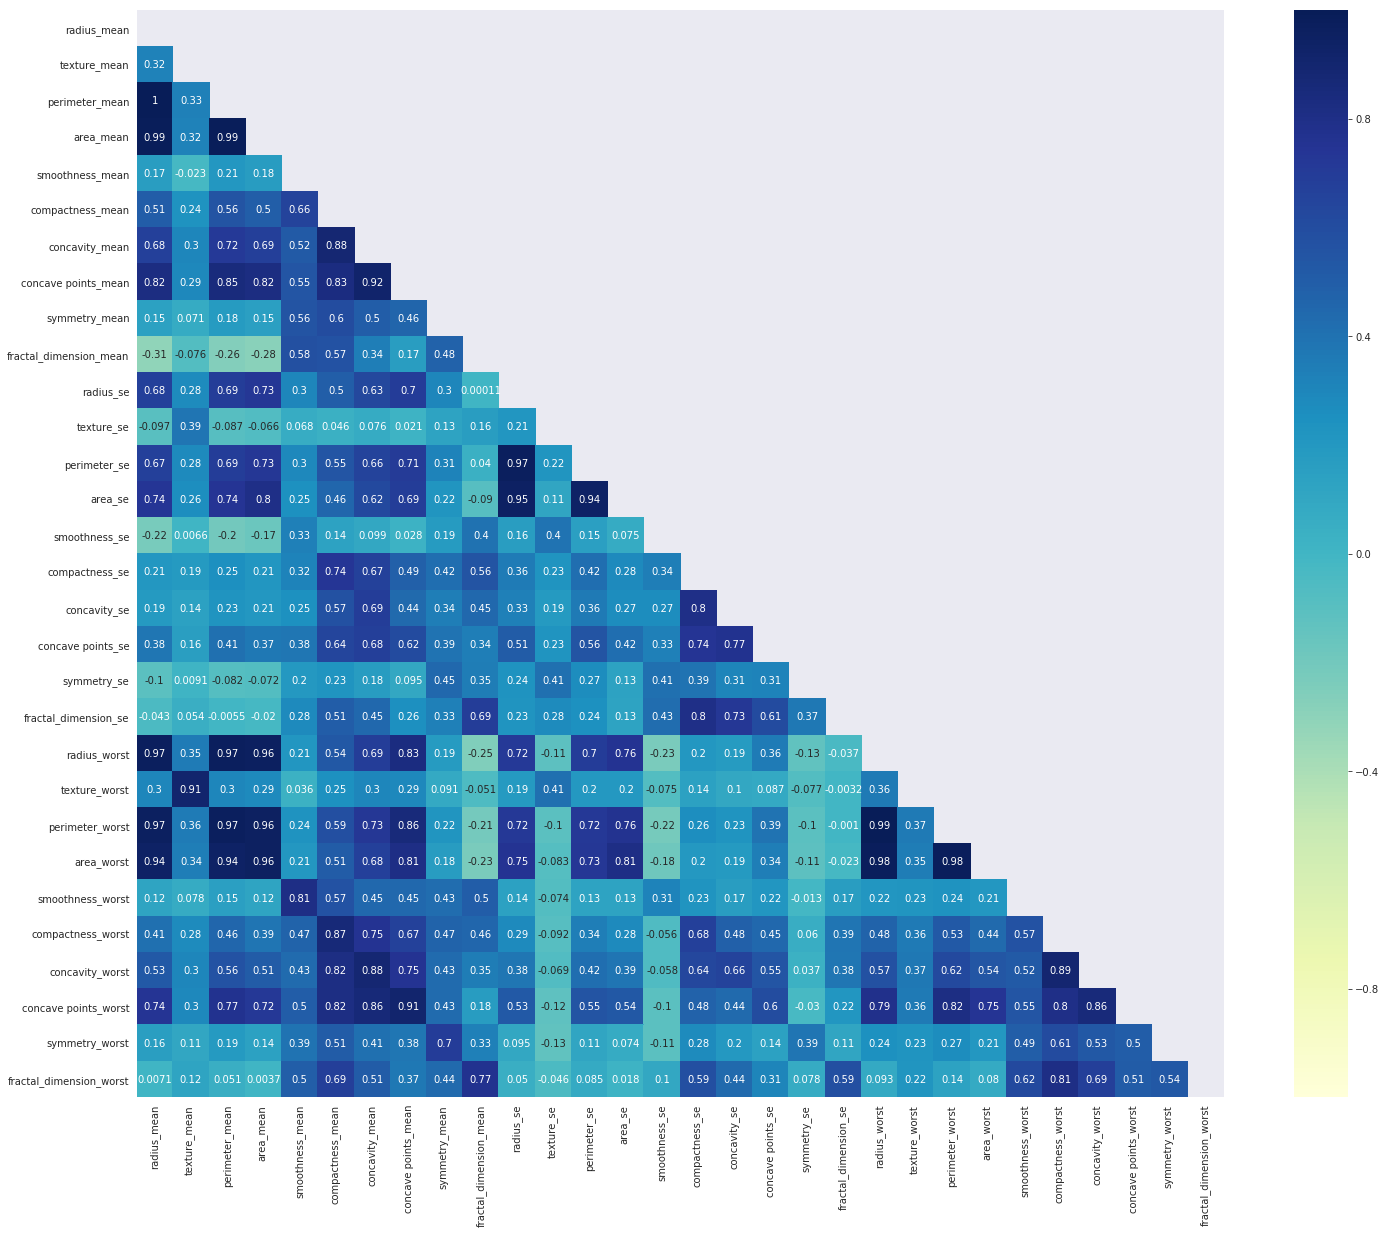

In [18]:
# Correlation plot helps me to inspect the relationship among numerical features.
# There might be a multicollinearity issue existed!
# For instance, perimeter_mean and radius_mean have a perfect positive correlation!
with sb.axes_style("darkgrid"):
    fig = plt.figure(figsize=(25,20))
    ax = sb.heatmap(correlation_matrix, mask = mask, 
                    vmin = -1, vmax = 1, square = True,
                    annot = True, cmap = "YlGnBu")

## 5.3 Distribution plots - categorical features

In [19]:
# Only one categorical feature included in the dataset, which is the response variable.
# There is no categorical predictor in the dataset.
for each in data.columns:
    if data[each].dtype == 'object':
        print(each)

diagnosis


## 5.4 Hypothesis testing - two sample t-test for numerical features

- **Before performing the two sample t-test, I need to determine whether two samples have the same variance by conducting the F-test.**

- **F-test, null (h0) and alternative (h1) hypotheses:**

$$H_0: \sigma_1^2 = \sigma_2^2$$

$$H_1: \sigma_1^2 \neq \sigma_2^2$$

- **F-test, 95% confidence interval for the estimator (if the C.I. contains 1, two variances are equal):**

$$C.I. = (\frac {1}{F_\frac{\alpha}{2}} \frac {s_1^2}{s_2^2}, \frac {1}{F_{1-\frac{\alpha}{2}}} \frac {s_1^2}{s_2^2})$$

In [20]:
# Helper function for performing an f-test to compare two sample variances.
def f_test_two_p_variance(var1, var2, n1, n2, alpha_level):
    '''
    Perform the F-test for comparing variances between two samples.
    Outputs: F ratio, p-value, and the confidence interval given an alpha level.
    
    var1: the variance of the population 1
    var2: the variance of the population 2
    n1: sample size of the population 1
    n2: sample size of the population 2
    alpha_level: can be either 0.1, 0.05, or 0.1
    '''
    # F test statistic
    F_ratio = var1 / var2
    
    # p-value (two-sided test: the interest is to compare whether two variances are equal)
    p_value = min(f.cdf(F_ratio, n1-1, n2-1), 1 - f.cdf(F_ratio, n1-1, n2-1))
    p_value = p_value*2

    # 95% C.I.
    upper = 1 / (f.ppf(alpha_level/2, n1-1, n2-1)) * F_ratio
    lower = 1 / (f.ppf(1 - (alpha_level/2), n1-1, n2-1)) * F_ratio
    
    return F_ratio, p_value, (lower, upper)

In [21]:
# Loop into numerical columns.
unequal_col = []
equal_col = []
for num_col in data.columns:
    if data[num_col].dtype != 'object':
        f_results = f_test_two_p_variance(var1=data[data.diagnosis == 'M'][num_col].var(), 
                                          var2=data[data.diagnosis == 'B'][num_col].var(), 
                                          n1=data[data.diagnosis == 'M'][num_col].count(), 
                                          n2=data[data.diagnosis == 'B'][num_col].count(), 
                                          alpha_level=0.05)
        print('Column name: {}.'.format(num_col))
        print('F ratio: {}.'.format(f_results[0]))
        print('p-value: {}.'.format(f_results[1]))
        print('95 C.I. {}.'.format(f_results[2]))
        if f_results[1] <= 0.05:
            print('Decision: reject H0, two variances are unequal.')
            unequal_col.append(num_col)
        else: 
            print('Decision: do not reject H0, two variances are equal.')
            equal_col.append(num_col)
        print('----------------------------------------------------')

Column name: radius_mean.
F ratio: 3.2380797668659986.
p-value: 2.220446049250313e-16.
95 C.I. (2.553313231336901, 4.137593399442609).
Decision: reject H0, two variances are unequal.
----------------------------------------------------
Column name: texture_mean.
F ratio: 0.8949548598759236.
p-value: 0.3748102607136292.
95 C.I. (0.7056960450922153, 1.1435664306088558).
Decision: do not reject H0, two variances are equal.
----------------------------------------------------
Column name: perimeter_mean.
F ratio: 3.425914542033665.
p-value: 2.220446049250313e-16.
95 C.I. (2.701426017701327, 4.377607229204353).
Decision: reject H0, two variances are unequal.
----------------------------------------------------
Column name: area_mean.
F ratio: 7.507243908136507.
p-value: 2.220446049250313e-16.
95 C.I. (5.919664301559354, 9.59269847523703).
Decision: reject H0, two variances are unequal.
----------------------------------------------------
Column name: smoothness_mean.
F ratio: 0.879260199802

In [22]:
# The total columns (predictors) must be 30.
len(unequal_col) + len(equal_col)

30

- **Two sample t-test, null (h0) and alternative (h1) hypotheses:**

$$H_0: \mu_1 = \mu_2$$

$$H_1: \mu_1 \neq \mu_2$$

In [23]:
# Perform two sample t-test to see whether they have 'different' means.
# If they are different to each other in the aspect of mean given a predictor, 
# then it might indicate this predictor has some prediction power 
# on the response variable(subscription).

# Collecting results.
t_test_results = np.array([])
t_test_p_values = np.array([])
num_col_names = np.array([])

# Loop into numerical columns.
for num_col in unequal_col:
    t_test_results = np.append(t_test_results,
                               (ttest_ind(a=data[data.diagnosis == 'M'][num_col], 
                                          b=data[data.diagnosis == 'B'][num_col], 
                                          equal_var=False))[0])
    t_test_p_value = ttest_ind(a=data[data.diagnosis == 'M'][num_col], 
                               b=data[data.diagnosis == 'B'][num_col], 
                               equal_var=False)[1]
    t_test_p_values = np.append(t_test_p_values, t_test_p_value)
    num_col_names = np.append(num_col_names, num_col)
    # Decision (reject or not reject H0)
    if t_test_p_value <= 0.05:
        print('Column name: {}.'.format(num_col))
        print('Decision: reject H0, two means are unequal.')
        print('p-value: {}.'.format(t_test_p_value))
    else:
        print('Column name: {}.'.format(num_col))
        print('Decision: do not reject H0, two means are equal.')
        print('p-value: {}.'.format(t_test_p_value))
    print('-------------------------------------------')

# Loop into numerical columns.
for num_col in equal_col:
    t_test_results = np.append(t_test_results,
                               (ttest_ind(a=data[data.diagnosis == 'M'][num_col], 
                                          b=data[data.diagnosis == 'B'][num_col], 
                                          equal_var=True))[0])
    t_test_p_value = ttest_ind(a=data[data.diagnosis == 'M'][num_col], 
                               b=data[data.diagnosis == 'B'][num_col], 
                               equal_var=True)[1]
    t_test_p_values = np.append(t_test_p_values, t_test_p_value)
    num_col_names = np.append(num_col_names, num_col)
    # Decision (reject or not reject H0)
    if t_test_p_value <= 0.05:
        print('Column name: {}.'.format(num_col))
        print('Decision: reject H0, two means are unequal.')
        print('p-value: {}.'.format(t_test_p_value))
    else:
        print('Column name: {}.'.format(num_col))
        print('Decision: do not reject H0, two means are equal.')
        print('p-value: {}.'.format(t_test_p_value))
    print('-------------------------------------------')

Column name: radius_mean.
Decision: reject H0, two means are unequal.
p-value: 1.6844591259582747e-64.
-------------------------------------------
Column name: perimeter_mean.
Decision: reject H0, two means are unequal.
p-value: 1.0231409970104587e-66.
-------------------------------------------
Column name: area_mean.
Decision: reject H0, two means are unequal.
p-value: 3.284366459573323e-52.
-------------------------------------------
Column name: compactness_mean.
Decision: reject H0, two means are unequal.
p-value: 9.607863145123788e-42.
-------------------------------------------
Column name: concavity_mean.
Decision: reject H0, two means are unequal.
p-value: 3.742120672313664e-58.
-------------------------------------------
Column name: concave points_mean.
Decision: reject H0, two means are unequal.
p-value: 3.1273162856782697e-71.
-------------------------------------------
Column name: radius_se.
Decision: reject H0, two means are unequal.
p-value: 1.4911328540231125e-30.
---

In [24]:
# Sort the t-test statistic result and return the corresponding indexes.
sort_index = abs(t_test_results).argsort()

In [25]:
# Absolute t-test statistics.
abs(t_test_results)[sort_index]

array([ 0.14205517,  0.20786502,  0.30571113,  1.59936481,  2.03623649,
        6.91630451,  7.29707744,  7.32272967,  8.33831179,  9.14609881,
        9.52950372, 10.64249782, 10.86720108, 11.06674661, 12.15555568,
       12.23098135, 12.83276275, 13.3007061 , 15.15687206, 15.81824587,
       19.59572599, 19.64099017, 20.33242456, 20.57081425, 22.20879776,
       22.93531377, 24.82974468, 24.84481004, 25.33220964, 29.11765918])

In [26]:
# Column names: From the least to the most important numerical feature.
num_col_names[sort_index]

array(['symmetry_se', 'texture_se', 'fractal_dimension_mean',
       'smoothness_se', 'fractal_dimension_se', 'concavity_se',
       'compactness_se', 'fractal_dimension_worst', 'symmetry_mean',
       'smoothness_mean', 'symmetry_worst', 'concave points_se',
       'texture_mean', 'smoothness_worst', 'area_se', 'texture_worst',
       'perimeter_se', 'radius_se', 'compactness_worst',
       'compactness_mean', 'concavity_worst', 'area_mean',
       'concavity_mean', 'area_worst', 'radius_mean', 'perimeter_mean',
       'radius_worst', 'concave points_mean', 'perimeter_worst',
       'concave points_worst'], dtype='<U32')

## 5.5 Overall feature selection summary

### Numerical predictors
- **'symmetry_se', 'texture_se', 'fractal_dimension_mean', and 'smoothness_se'** didn't pass the two sample t-test because their p-values are larger than 0.05. Therefore, these four features are not good predictors to differentiate response variables.
- **fractal_dimension_se** passed the test, but notice that the p-value is very close to 0.05.
- **concave points_worst might be the most important predictor among all features observed from the test result.** 
    - description: "worst" or largest mean value for number of concave portions of the contour.

    
| Column name | Rank |
| -- | -- |
| perimeter_mean | 5
| radius_worst | 4
| concave points_mean | 3
| perimeter_worst | 2
| **concave points_worst** | 1 